## Authenticate to Colab, Cloud and GEE

In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Imperial_2'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Imperial_2016_28c/'
# IMAGES_PATH = base_dir + '/' + 'Imperial_2016/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [2]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [3]:
LABEL = 'landcover'


landcovers = ["Alfalfa", "Other Pasture", "Lettuce", "Wheat", "Onions", "Other Truck Crops", "Corn", "Other Field Crops",
             "Subtropical", "Other"]
# landcovers = ["Alfalfa", "Other Pasture", "Wheat", "Onion", "Lettuce", "Other crops","Subtropical", "Other"]
nClasses = len(landcovers)
r = 7

In [4]:
new_labels = tf.constant([8, 8, 8, 8, 9, 6, 7, 7, 9, 3, 9, 0, 1, 1, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 5, 9, 9, 9], dtype = tf.int32,)
# new_labels = tf.constant([6, 6, 6, 6, 7, 5, 5, 5, 7, 2, 7, 0, 1, 1, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 5, 7, 7, 7], dtype = tf.int32)

new_labels

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([8, 8, 8, 8, 9, 6, 7, 7, 9, 3, 9, 0, 1, 1, 5, 5, 5, 5, 2, 5, 5, 4,
       5, 5, 5, 9, 9, 9], dtype=int32)>

In [5]:
train_path = IMAGES_PATH + 'training_imperial_2016_28c'
validation_path = IMAGES_PATH + 'validation_imperial_2016_28c'
test_path = IMAGES_PATH + 'testing_imperial_2016_28c'
# train_path = IMAGES_PATH + 'training_imperial_2016'
# validation_path = IMAGES_PATH + 'validation_imperial_2016'
# test_path = IMAGES_PATH + 'testing_imperial_2016'

train_file_prefix = 'training_imperial_2016'
validation_file_prefix = 'validation_imperial_2016'
test_file_prefix = 'testing_imperial_2016'


def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [6]:
validation_dataset_paths

['/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_1.tfrecord.gz',
 '/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_2.tfrecord.gz',
 '/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_4.tfrecord.gz',
 '/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_3.tfrecord.gz',
 '/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_5.tfrecord.gz',
 '/content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2/Imperial_2016_28c/validation_imperial_2016_28c/validation_imperial_2016_6.tfrecord.gz',
 '/content/gdrive/My Drive/Colab N

In [8]:
FEATURE_NAMES = []
bands =  [
          'B2', 'B3', 'B4', 'B8', 'B11','B12', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI',
          ]# bands =  ['NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']

# bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7']

time_stamps = 12
n_features = len(bands)
# for i in range(2,11):
#   if i > 0:
#     s = [b + '_' + str(i) for b in bands]
#   else:
#     s = bands
#   FEATURE_NAMES.extend(s)
# FEATURE_NAMES.append(LABEL)
for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)

# Data preparation and pre-processing

In [9]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [10]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    for f in FEATURE_NAMES[i:i+n_features]:
      # if f.startswith('B'):
      #   spectral.append(tf.reshape(data[f],(r,r))/10000)
      # else:   
      spectral.append(tf.reshape(data[f],(r,r)))
  
  spectral = tf.transpose(spectral, [1,2,0])
  label = tf.gather(new_labels, label)

  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [11]:
for data, target in testDataset.take(5):
  print(data.shape)
  # print(data)
  print(target)

(7, 7, 156)
tf.Tensor(0, shape=(), dtype=int32)
(7, 7, 156)
tf.Tensor(1, shape=(), dtype=int32)
(7, 7, 156)
tf.Tensor(2, shape=(), dtype=int32)
(7, 7, 156)
tf.Tensor(0, shape=(), dtype=int32)
(7, 7, 156)
tf.Tensor(5, shape=(), dtype=int32)


# 2D CNN

In [12]:
pad = 'same'
l2 = 0
l1 = 0

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape = ( r, r, time_stamps*n_features),),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
#     tf.keras.layers.Dense(14, activation = 'softmax')
# ])
# model.summary()
def unit(f = 60):
    model = tf.keras.Sequential([   
      tf.keras.layers.Conv2D(filters = f, kernel_size = (5, 5), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(filters = f, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(f, activation = 'relu'),
    ])
    return model

def model():
  input = tf.keras.layers.Input(shape = ( r, r, time_stamps*n_features))
  x = tf.keras.layers.BatchNormalization()(input)
  unit1 = unit(160)(x)
  unit2 = unit(170)(x)
  unit3 = unit(180)(x)
  unit4 = unit(190)(x)
  unit5 = unit(200)(x)
  x = tf.keras.layers.Concatenate()([unit1, unit2, unit3, unit4, unit5])
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(nClasses, activation = 'softmax')(x)
  model = tf.keras.Model(input, x)
  return model

model = model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 7, 156)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 156)    624         input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 160)          880480      batch_normalization[0][0]        
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 170)          952510      batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model)

In [13]:
batch_size = 128
num_epochs = 60

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=1e-10, min_delta=0.01, verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_dir + '/model3_conv2d_2016_7x7x156', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

optim = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

history = model.fit(trainDataset.batch(batch_size), 
                    batch_size=batch_size, 
                    epochs=num_epochs, verbose=1,
                    validation_data = alltestDataset.batch(batch_size),
                    callbacks = [reduce_lr, 
                                 model_checkpoint_callback
                                 ]
)

Epoch 1/60
1635/1635 [==============================] - 802s 486ms/step - loss: 0.6338 - accuracy: 0.7965 - val_loss: 0.5982 - val_accuracy: 0.8234
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2models/model3_conv2d_2016_7x7x156/assets
Epoch 2/60
1635/1635 [==============================] - 197s 120ms/step - loss: 0.2861 - accuracy: 0.9014 - val_loss: 0.7281 - val_accuracy: 0.8172
Epoch 3/60
1635/1635 [==============================] - 188s 115ms/step - loss: 0.1888 - accuracy: 0.9362 - val_loss: 0.8844 - val_accuracy: 0.8169

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00017999999545281753.
Epoch 4/60
1635/1635 [==============================] - 189s 115ms/step - loss: 0.1267 - accuracy: 0.9582 - val_loss: 0.9460 - val_accuracy: 0.8191
Epoch 5/60
1635/1635 [==============================] - 189s 115ms/step - loss: 0.0983 - accuracy: 0.9677 - val_loss: 1.1429 - val_accuracy: 0.8199

Epoch 00005: ReduceLROnPlateau 

KeyboardInterrupt: ignored

In [ ]:
# model = tf.keras.models.load_model(model_dir + '/model2_conv2d_2016_7x7x117')
model = tf.keras.models.load_model(model_dir + '/model3_conv2d_2016_7x7x156')


In [ ]:
model.evaluate(alltestDataset.batch(1000))

135/135 [==============================] - 70s 504ms/step - loss: 4.1551 - accuracy: 0.7970


[4.155096054077148, 0.796989917755127]

## Analysis

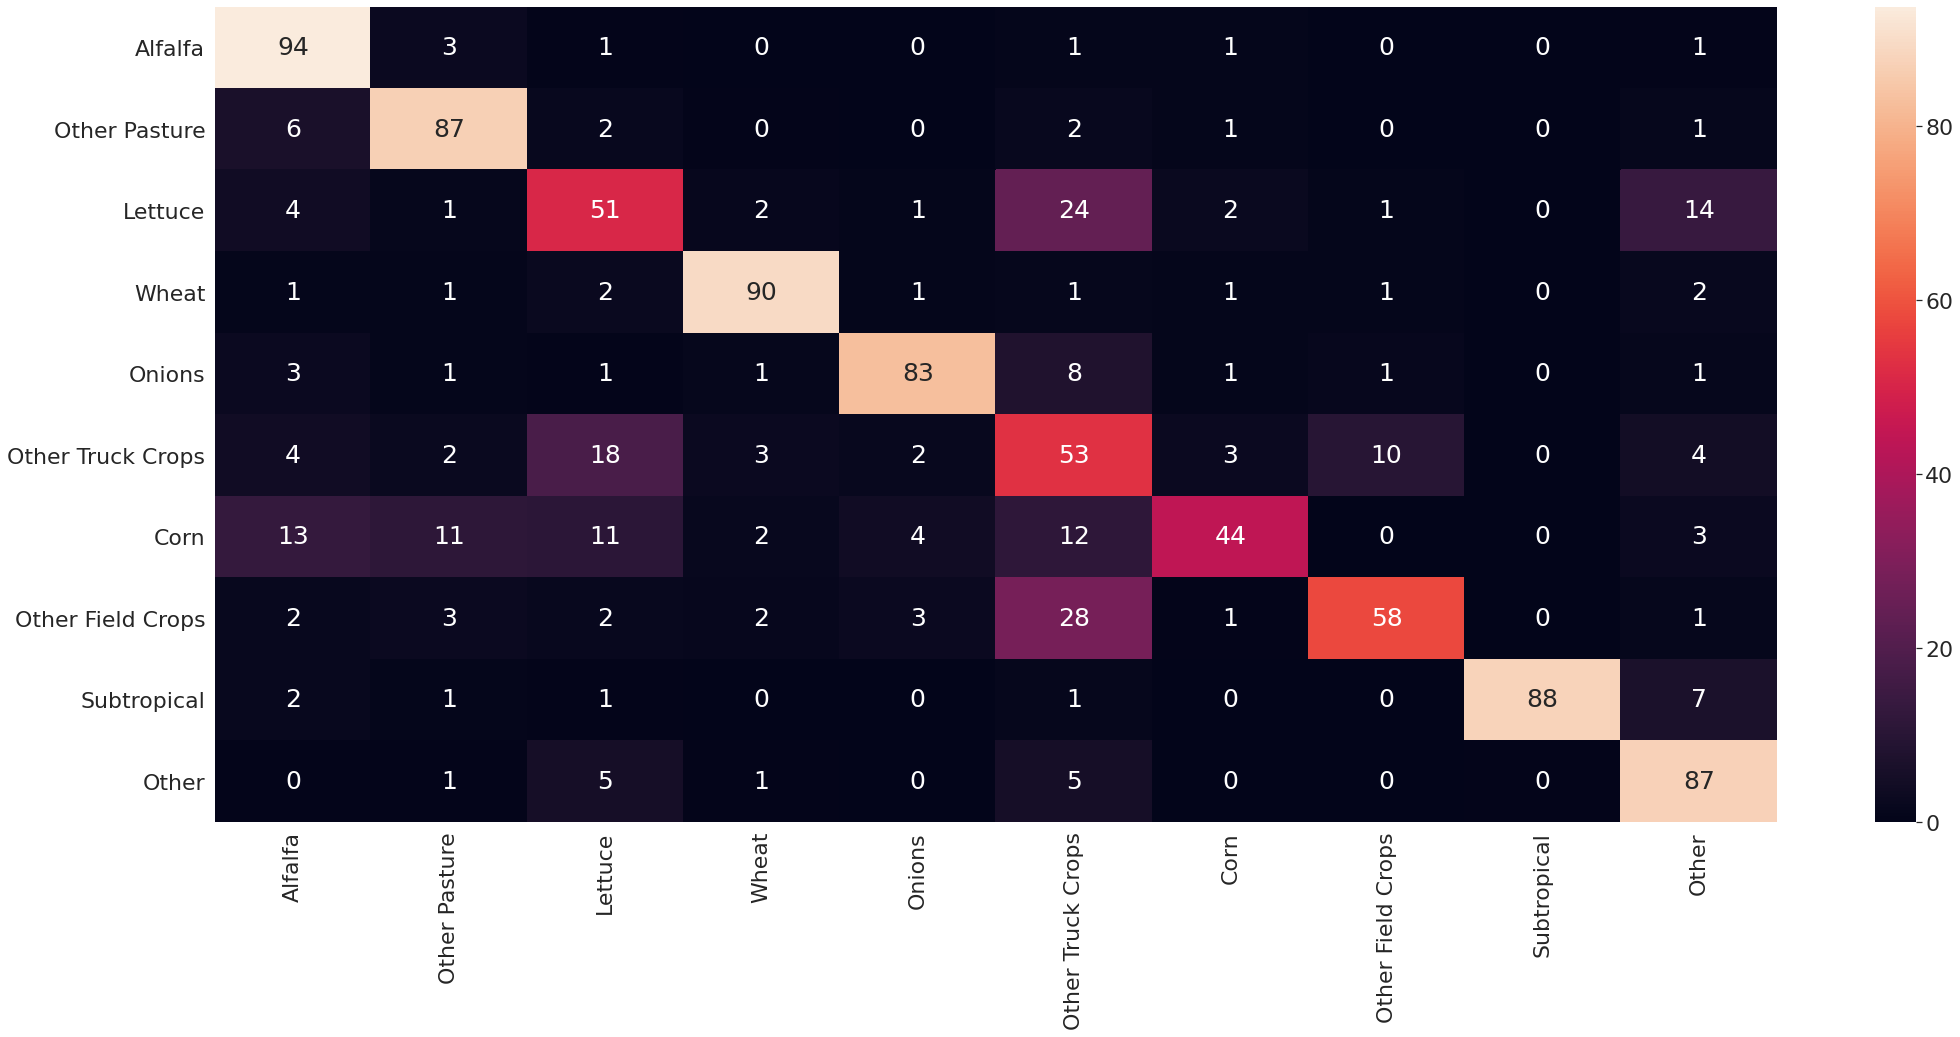

In [ ]:
# from sklearn.metrics import f1_score
# y_pred = np.argmax(model.predict(alltestDataset.batch(1000)),axis = 1)
# y_true = tf.concat([y for x, y in alltestDataset], axis=0)

# cf = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

# print(cf)
# s = np.sum(cf, axis = 1)

# cf1 = pd.DataFrame(cf/(s.reshape(nClasses-1, 1)), columns=landcovers[:-1], index = landcovers[:-1])
cf1 = pd.DataFrame((cf/(s.reshape(10, 1)))*100, columns=landcovers, index = landcovers)

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f');

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average = 'weighted')

0.7948138481273697